In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Loading and Normalizing CIFAR-10
   The CIFAR-10 dataset contains 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

In [2]:
# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4
# Download and load training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# Download and load test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


## Why Normalize?
We normalize the images with mean=0.5 and standard deviation=0.5 for each channel (RGB) to help the model converge faster during training

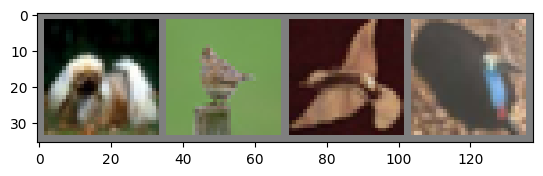

dog  bird bird bird 


In [3]:
def imshow(img):
    img=img/2+0.5 #unormalize
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

# Get somerandom training images
dataiter=iter(trainloader)
images,labels=next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))
# print lables
print(''.join(f'{classes[labels[j]]:5s}'for j in range (batch_size)))

##  Convolutional Neural Network

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channels, 6 output channels, 5x5 square convolution
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        # 6 input channels, 16 output channels, 5x5 convolution
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
            # First conv block: conv -> relu -> pool
            x = self.pool(F.relu(self.conv1(x)))
            # Second conv block: conv -> relu -> pool
            x = self.pool(F.relu(self.conv2(x)))
            # Flatten for fully connected layers
            x = torch.flatten(x, 1)
            # Fully connected layers with ReLU activation
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            # Final output layer (no activation)
            x = self.fc3(x)
            return x
net = Net()

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.03, momentum=0.9)

In [6]:
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=72,
    shuffle=True
)

net.train()  # put model in training mode

for epoch in range(20):  
    running_loss = 0.0

    for inputs, labels in trainloader:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    print(f"Epoch [{epoch + 1}/20] Loss: {avg_loss:.4f}")

print("Finished Training")


Epoch [1/20] Loss: 1.7094
Epoch [2/20] Loss: 1.3458
Epoch [3/20] Loss: 1.2273
Epoch [4/20] Loss: 1.1394
Epoch [5/20] Loss: 1.0865
Epoch [6/20] Loss: 1.0487
Epoch [7/20] Loss: 1.0079
Epoch [8/20] Loss: 0.9748
Epoch [9/20] Loss: 0.9467
Epoch [10/20] Loss: 0.9330
Epoch [11/20] Loss: 0.9125
Epoch [12/20] Loss: 0.9097
Epoch [13/20] Loss: 0.9063
Epoch [14/20] Loss: 0.8897
Epoch [15/20] Loss: 0.8753
Epoch [16/20] Loss: 0.8688
Epoch [17/20] Loss: 0.8572
Epoch [18/20] Loss: 0.8511
Epoch [19/20] Loss: 0.8408
Epoch [20/20] Loss: 0.8441
Finished Training


## save our traing model

In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Testing the Network
Now let’s see how our model performs on unseen test data:



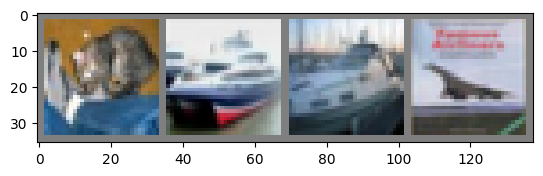

GroundTruth:  cat   ship  ship  plane


In [8]:
# Load some test images
dataiter = iter(testloader)
images, labels = next(dataiter)
# Display images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

##  let’s see what our model predicts

In [9]:
# Reload our model
net = Net()
net.load_state_dict(torch.load(PATH))

# Get predictions
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', " ".join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   ship  truck plane


## overall accuracy on the entire test set

In [10]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy of the network on the 10000 test images: {100 * correct // total} %")

Accuracy of the network on the 10000 test images: 58 %
